<a href="https://colab.research.google.com/github/sawantshaurya1093-bit/Research-Paper/blob/main/Cohortanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cohort analysis is a valuable technique for understanding how certain characteristics influence user behaviour. This analysis is performed by assigning users to homogenous groups (cohorts), based on a characteristic they have exhibited during a set period of time. Depending on business model and purpose of the analysis, this period could be a day, week, month, or even a year.

In [2]:
import pandas as pd
import datetime as dt

df=pd.read_csv("events.csv").drop(['product_id','category_id','category_code','brand','price','user_session'],axis=1)
df.head()

,event_time,event_type,user_id
0,2020-09-24 11:57:06 UTC,view,1515915625519388267
1,2020-09-24 11:57:26 UTC,view,1515915625519380411
2,2020-09-24 11:57:27 UTC,view,1515915625513238515
3,2020-09-24 11:57:33 UTC,view,1515915625519014356
4,2020-09-24 11:57:36 UTC,view,1515915625510743344


# Extracting Cohort Date

The first step in creating our cohorts will be extracting the year & month from the event_time values. These extracted values will be stored in the new column, current_date.

As event_time is of string type, before using the datetime library (dt) to extract these date parts, it must first be converted to a datetime-like object. This can be achieved simply, using the pd.to_datetime() function.

To create a value that is consistent across all months, the day “01” has been concatenated to the year & month values extracted from event_time. The resulting string has then been converted to a date, which will help with the ordering of data in the later pivot table.

In [5]:
df['current_month']=pd.to_datetime(df['event_time']).dt.year.map(str) \
                      +"-"+pd.to_datetime(df['event_time']).dt.month.map(str)+"-"'01'
df['current_month']=pd.to_datetime(df['current_month']).dt.date

In [6]:
df["cohort_month"]=df.groupby("user_id")["current_month"].transform("min")

# Creating a Cohort Index

In [7]:
def cohort_index(df, col1, col2):
  current_year=pd.to_datetime(df[col1]).dt.year
  current_month=pd.to_datetime(df[col2]).dt.month
  cohort_year=pd.to_datetime(df[col1]).dt.year
  cohort_month=pd.to_datetime(df[col2]).dt.month
  return(current_year-cohort_year) * 12 + current_month - cohort_month
df['cohort_index']=cohort_index(df,"current_month","cohort_month")

 the first function (months_diff) extracts the month integer from both current_month & cohort_month values . The value returned is the product of the current month, minus the cohort month.

In [8]:
def months_diff(df, col1, col2):
    current_month = pd.to_datetime(df[col1]).dt.month
    cohort_month = pd.to_datetime(df[col2]).dt.month
    return current_month - cohort_month

df['months_diff'] = months_diff(df, 'current_month', 'cohort_month')

The years_diff function follows the same template, this time subtracting the year integer values from current_month & cohort_month columns.

In [9]:
def years_diff(df, col1, col2):
    current_year = pd.to_datetime(df[col1]).dt.year
    cohort_year = pd.to_datetime(df[col2]).dt.year
    return current_year - cohort_year

df['years_diff'] = years_diff(df, 'current_month', 'cohort_month')

cohort index can be created by passing these two new columns as arguments to the cohort_index function. It is important to note that values in the years_diff column are converted to months, by multiplying them by 12, before adding them to values from the months_diff column.

In [10]:
def cohort_index(df, col1, col2):
    return df[col1] * 12 + df[col2]

df['cohort_index'] = cohort_index(df, 'years_diff', 'months_diff')

# Calculating Cohort Sizes & Retention

In [11]:
cohort_counts = df.groupby(['cohort_month', 'cohort_index'])['user_id'].nunique()

cohort_counts_df = cohort_counts.to_frame().rename(columns={'user_id':'users'}) \
                                .sort_values(by=['cohort_month'])

In [12]:
cohort_counts_df['retention_rate'] = cohort_counts_df['users'] / cohort_counts_df.groupby(["cohort_month"])["users"].transform("max")

 pivot_table method to the cohort_counts_df DataFrame, setting the rows to ‘cohort_month’, columns to ‘cohort_index’ and values to ‘retention_rate’:

In [13]:
cohorts_pivot = cohort_counts_df.pivot_table(index='cohort_month', columns = 'cohort_index', values = 'retention_rate')

# Visualising Cohorts for Analysis

<Axes: xlabel='cohort_index', ylabel='cohort_month'>

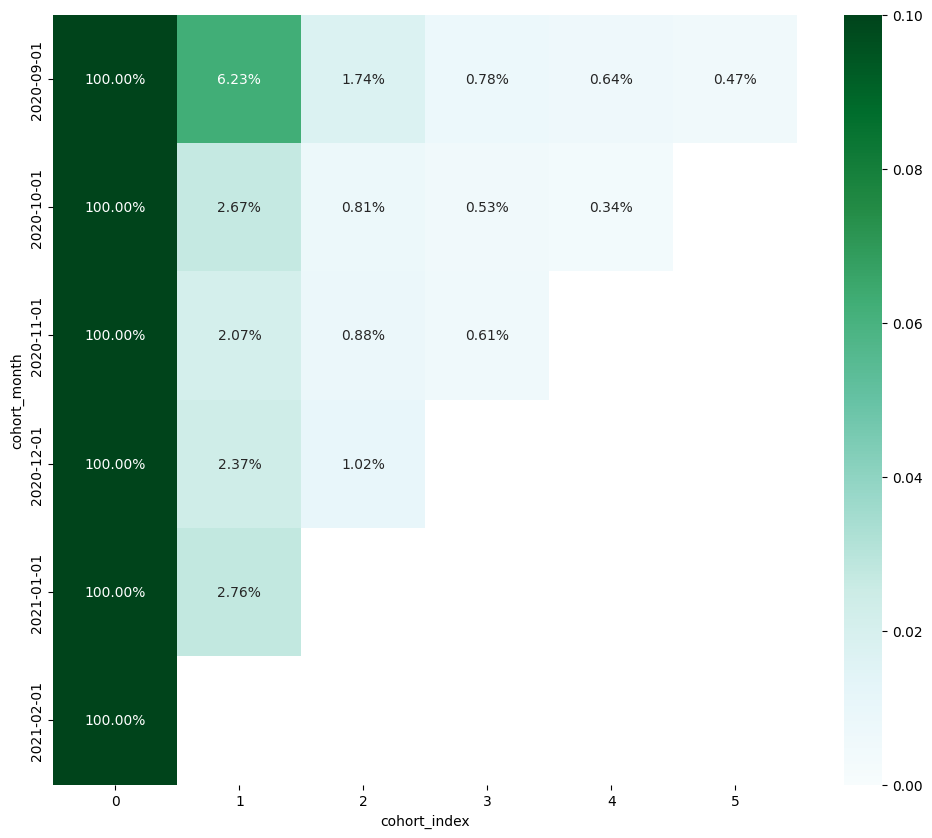

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 10))
sns.heatmap(data = cohorts_pivot,
            annot = True,
            fmt = '.2%',
            vmin = 0.0,
            vmax = 0.1,
            cmap = 'BuGn')

# Conclusion

So there we have it, an easy to interpret visualisation for analysing cohort behaviour over time. Leveraging pandas, this can be used to assist with the creation of more effective acquisition and retention strategies — ultimately driving sustainable business growth.